# Helper Functions

In [ ]:
import os
root_path = '/raid/ee-mariyam/maryam/abhijeet/Combined_Files'
def get_jpg_paths(base_dir):
    jpg_dict = {}
    
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        
        if os.path.isdir(folder_path):
            jpg_paths = []
            
            for file_name in os.listdir(folder_path):
                if file_name.lower().endswith('.jpg'):
                    file_path = os.path.join(folder_path, file_name)
                    jpg_paths.append(file_path)
            
            if jpg_paths:
                jpg_dict[folder_name] = jpg_paths
    
    return jpg_dict

combined_files_path = root_path
jpg_paths_dict = get_jpg_paths(combined_files_path)


In [2]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F 
import cv2
from PIL import Image


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def evaluate_model(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    return all_labels, all_preds



In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, num_classes, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_names,
                yticklabels=class_names)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
def plot_losses_and_accuracies(train_losses, val_losses, train_accuracies, val_accuracies):

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='green')
    plt.plot(val_accuracies, label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_classwise_accuracy(cm, jpg_paths_dict):
    total_accuracy = np.trace(cm) / np.sum(cm)

    classwise_accuracy = cm.diagonal() / cm.sum(axis=1)

    class_names = list(jpg_paths_dict.keys())  
    classwise_accuracy = [
        acc if cm.sum(axis=1)[i] > 0 else np.nan
        for i, acc in enumerate(classwise_accuracy)
    ]

    print(f"Total Accuracy: {total_accuracy * 100:.2f}%")
    for i, accuracy in enumerate(classwise_accuracy):
        if np.isnan(accuracy):
            print(f"Class '{class_names[i]}' Accuracy: N/A (no samples)")
        else:
            print(f"Class '{class_names[i]}' Accuracy: {accuracy * 100:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, classwise_accuracy, color='skyblue')
    plt.ylabel('Accuracy')
    plt.title('Class-wise Accuracy')
    plt.ylim(0, 1)  
    plt.axhline(total_accuracy, color='red', linestyle='--', label='Total Accuracy')
    plt.xticks(rotation=45) 
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()  
    plt.show()

In [9]:
for subfolder, jpg_files in jpg_paths_dict.items():
    print(f"Subfolder: {subfolder}")
    print(f"Number of JPEG files: {len(jpg_files)}")
    print()

Subfolder: Purple_Blotch
Number of JPEG files: 406

Subfolder: Thrips
Number of JPEG files: 546

Subfolder: IYSV
Number of JPEG files: 754

Subfolder: Twister
Number of JPEG files: 317

Subfolder: Healthy
Number of JPEG files: 1072

Subfolder: Bulb Rot
Number of JPEG files: 669

Subfolder: Basal_Rot
Number of JPEG files: 140

Subfolder: Stemphylium
Number of JPEG files: 661

Subfolder: Anthracnose
Number of JPEG files: 765



In [10]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, jpg_files_dict, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {}
        self._prepare_data(jpg_files_dict)

    def _prepare_data(self, jpg_files_dict):
        for label_idx, (subfolder, file_paths) in enumerate(jpg_files_dict.items()):
            self.label_map[subfolder] = label_idx
            for file_path in file_paths:
                self.image_paths.append(file_path)
                self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, IOError) as e:
            print(f'Error loading image {img_path}: {e}')
            image = Image.new('RGB', (224, 224))
            label = self.labels[idx]
        else:
            label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# DenseNet121 without Twister class

In [11]:
jpg_paths_without_twister_dict = {
    key: value for key, value in jpg_paths_dict.items() if key != 'Twister'
}

In [12]:
for subfolder, jpg_files in jpg_paths_without_twister_dict.items():
    print(f"Subfolder: {subfolder}")
    print(f"Number of JPEG files: {len(jpg_files)}")
    print()

Subfolder: Purple_Blotch
Number of JPEG files: 406

Subfolder: Thrips
Number of JPEG files: 546

Subfolder: IYSV
Number of JPEG files: 754

Subfolder: Healthy
Number of JPEG files: 1072

Subfolder: Bulb Rot
Number of JPEG files: 669

Subfolder: Basal_Rot
Number of JPEG files: 140

Subfolder: Stemphylium
Number of JPEG files: 661

Subfolder: Anthracnose
Number of JPEG files: 765



In [91]:
dataset = CustomImageDataset(jpg_files_dict=jpg_paths_without_twister_dict, transform=transform)


In [92]:

import numpy as np
import torch
class_counts = []
for subfolder, jpg_files in jpg_paths_without_twister_dict.items():
    class_counts.append(len(jpg_files))
def compute_class_weights(label_map, dataset):
    print(class_counts)
    class_weights = np.max(class_counts) / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    print(class_weights)
    return class_weights

class_weights = compute_class_weights(dataset.label_map, dataset)
criterion = nn.CrossEntropyLoss(weight=class_weights)


[406, 546, 754, 1072, 669, 140, 661, 765]
tensor([2.6404, 1.9634, 1.4218, 1.0000, 1.6024, 7.6571, 1.6218, 1.4013],
       device='cuda:0')


In [93]:

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=32)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=32)

In [94]:
dataset.label_map

{'Purple_Blotch': 0,
 'Thrips': 1,
 'IYSV': 2,
 'Healthy': 3,
 'Bulb Rot': 4,
 'Basal_Rot': 5,
 'Stemphylium': 6,
 'Anthracnose': 7}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

model = models.densenet121(pretrained=True)

num_classes = len(jpg_paths_without_twister_dict)

model.classifier = nn.Linear(model.classifier.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

model = models.densenet121(pretrained=True)


in_features = model.classifier.in_features  

mlp_classifier = nn.Sequential(
    nn.Linear(in_features, 512),  
    nn.ReLU(),                   
    nn.Dropout(0.5),
    nn.Linear(512, 256),          
    nn.ReLU(),                    
    nn.Dropout(0.5),              
    nn.Linear(256, num_classes) 
)

model.classifier = mlp_classifier

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


In [ ]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects / total

        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_corrects += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects / val_total

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs} '
              f'Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_acc:.4f} '
              f'Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'denset121_without_twister.pth')
            print(f'Saved best model with accuracy: {best_acc:.4f}')

    print('Training complete.')
    print(f'Best Validation Accuracy: {best_acc:.4f}')
    return train_losses, val_losses, train_accuracies, val_accuracies


train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)



Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet

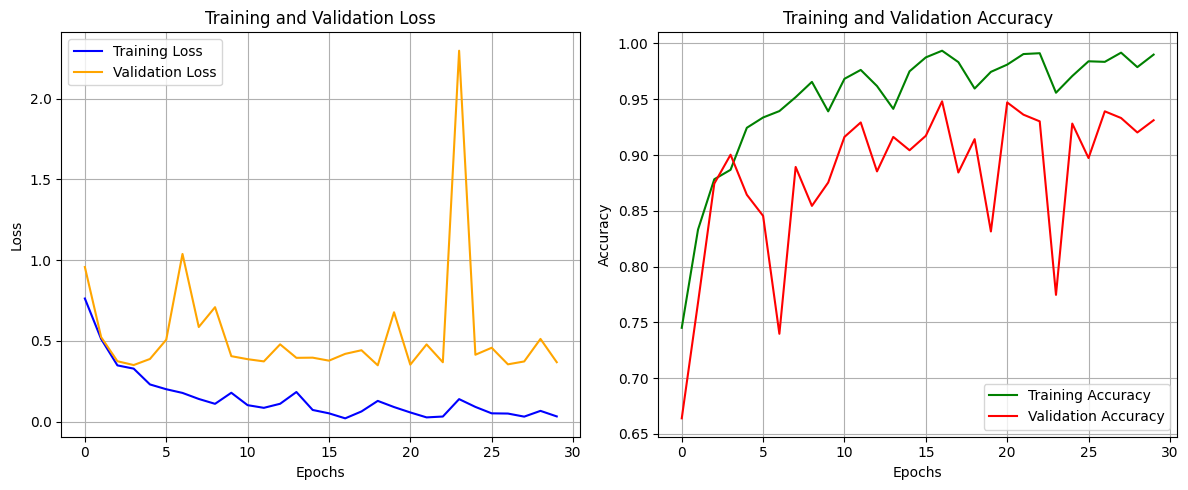

In [101]:
plot_losses_and_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)

In [29]:
model.load_state_dict(torch.load('denset121_without_twister.pth'))
all_labels, all_preds = evaluate_model(model, val_loader)

Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file


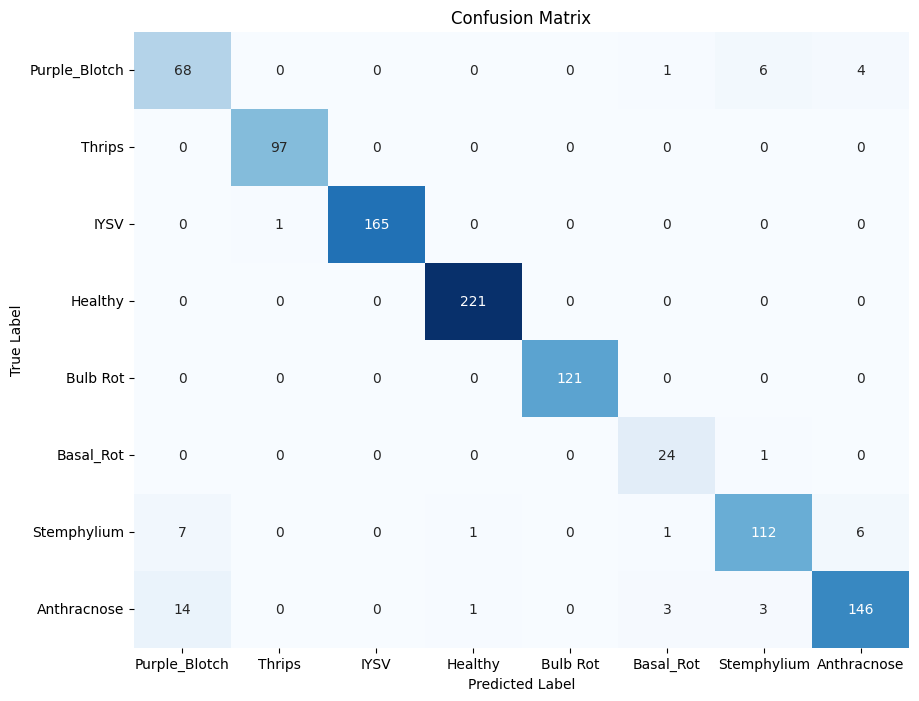

In [33]:
cm = confusion_matrix(all_labels, all_preds)
class_names = jpg_paths_without_twister_dict.keys()
num_classes=len(jpg_paths_without_twister_dict)
plot_confusion_matrix(cm, num_classes, class_names )

Total Accuracy: 95.11%
Class 'Purple_Blotch' Accuracy: 86.08%
Class 'Thrips' Accuracy: 100.00%
Class 'IYSV' Accuracy: 99.40%
Class 'Healthy' Accuracy: 100.00%
Class 'Bulb Rot' Accuracy: 100.00%
Class 'Basal_Rot' Accuracy: 96.00%
Class 'Stemphylium' Accuracy: 88.19%
Class 'Anthracnose' Accuracy: 87.43%


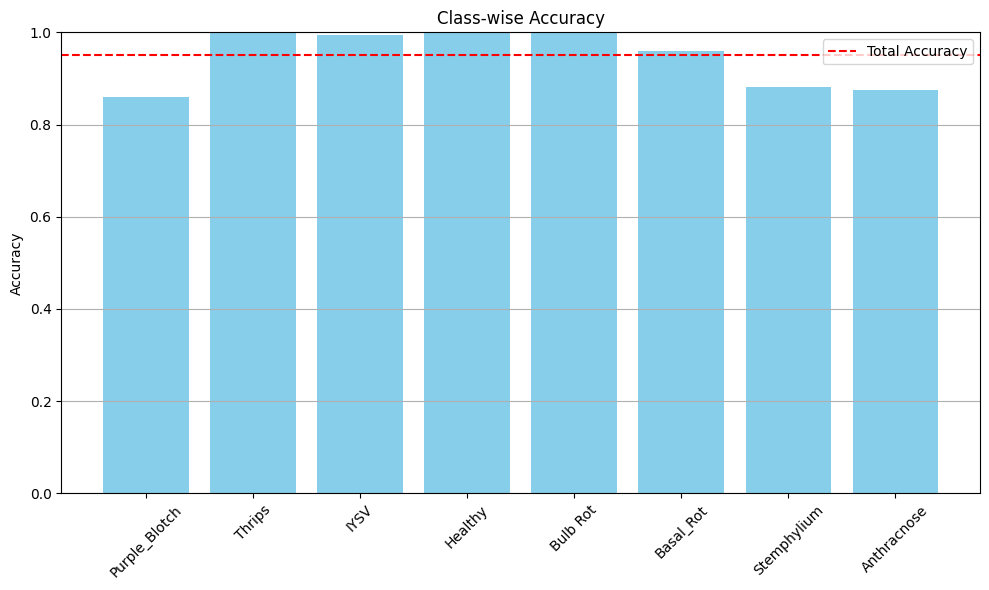

In [34]:
plot_classwise_accuracy(cm, jpg_paths_without_twister_dict)

# DenseNet121 with Anthracnose and Twister combined

In [11]:
jpg_paths_comb_dict = jpg_paths_dict.copy()
anthra = jpg_paths_comb_dict['Anthracnose']
twist = jpg_paths_comb_dict['Twister']
antra_twist = anthra+twist
jpg_paths_comb_dict['Antracnose_Twister'] = antra_twist

jpg_paths_comb_dict.pop('Anthracnose', None)
jpg_paths_comb_dict.pop('Twister', None)


['/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister/D E6 06.10.2023 DSC_3185.JPG',
 '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister/D E6 06.10.2023 DSC_3244.JPG',
 '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister/D E6 14.11.2023 DSC_6556.JPG',
 '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister/S E6 25.10.2023 IMG_20231025_094620957.jpg',
 '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister/D E6 14.11.2023 DSC_6553.JPG',
 '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister/S E6 25.10.2023 IMG_20231025_094709204.jpg',
 '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister/D E6 06.10.2023 DSC_3270.JPG',
 '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister/D E6 17.11.2023 DSC_6919.JPG',
 '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister/S E6 06.10.2023 IMG_20231006_163321~2.jpg',
 '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister/S E6 07.10.2023 IMG20231007113350.jpg',
 '/raid/ee-mariyam/maryam/abhijeet/Combined_Files/Twister/S 

In [12]:
for subfolder, jpg_files in jpg_paths_comb_dict.items():
    print(f"Subfolder: {subfolder}")
    print(f"Number of JPEG files: {len(jpg_files)}")
    print()

Subfolder: Purple_Blotch
Number of JPEG files: 406

Subfolder: Thrips
Number of JPEG files: 546

Subfolder: IYSV
Number of JPEG files: 754

Subfolder: Healthy
Number of JPEG files: 1072

Subfolder: Bulb Rot
Number of JPEG files: 669

Subfolder: Basal_Rot
Number of JPEG files: 140

Subfolder: Stemphylium
Number of JPEG files: 661

Subfolder: Antracnose_Twister
Number of JPEG files: 1082



In [17]:
import numpy as np
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import StratifiedKFold
dataset = CustomImageDataset(jpg_files_dict=jpg_paths_comb_dict, transform=transform)

labels = np.array(dataset.labels)

num_total = len(dataset)
num_train_val = int(0.8 * num_total)
num_test = num_total - num_train_val
indices = np.arange(num_total)
np.random.seed(42)
np.random.shuffle(indices)

train_val_indices = indices[:num_train_val]
test_indices = indices[num_train_val:]

train_val_labels = labels[train_val_indices]
test_labels = labels[test_indices]
train_val_dataset = Subset(dataset, train_val_indices)
test_dataset = Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=64)

In [18]:

import numpy as np
import torch
class_counts = []
for subfolder, jpg_files in jpg_paths_comb_dict.items():
    class_counts.append(len(jpg_files))
def compute_class_weights(label_map, dataset):
    print(class_counts)
    class_weights = np.max(class_counts) / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    print(class_weights)
    return class_weights

class_weights = compute_class_weights(dataset.label_map, dataset)
criterion = nn.CrossEntropyLoss(weight=class_weights)


[406, 546, 754, 1072, 669, 140, 661, 1082]
tensor([2.6650, 1.9817, 1.4350, 1.0093, 1.6173, 7.7286, 1.6369, 1.0000],
       device='cuda:0')


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class DenseNet121MLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base = models.densenet121(pretrained=True)
        
        self.base.classifier = nn.Identity()  
        
        self.mlp = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.base.features(x)  
        out = nn.functional.adaptive_avg_pool2d(features, (1, 1)).view(features.size(0), -1) 
        out = self.mlp(out)
        return out


In [20]:
class_names = jpg_paths_comb_dict.keys()


In [25]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5, fold=None, save_dir='./Models', final=False):
    best_acc = 0.0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects / total

        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_corrects += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects / val_total

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs} '
              f'Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_acc:.4f} '
              f'Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}')

        if not final and val_acc > best_acc:
            best_acc = val_acc
            save_path = f'{save_dir}/model_fold_basic_{fold}.pth'
            torch.save(model.state_dict(), save_path)
            print(f'Saved best model for fold {fold} with accuracy: {best_acc:.4f}')

    if final:
        save_path = f'{save_dir}/final_model_basic.pth'
        torch.save(model.state_dict(), save_path)
        print(f'Final model saved to {save_path}')
    else:
        print(f'Best Validation Accuracy for fold {fold}: {best_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies, (best_acc if not final else None)


In [ ]:
import torch
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
class_names = list(jpg_paths_comb_dict.keys())

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
fold_best_accuracies = []

all_true_labels_cv = []
all_pred_labels_cv = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_indices, train_val_labels)):
    print(f"\n--- Fold {fold + 1} ---")

    fold_train_dataset = Subset(train_val_dataset, train_idx)
    fold_val_dataset = Subset(train_val_dataset, val_idx)

    train_loader = DataLoader(fold_train_dataset, batch_size=32, shuffle=True, num_workers=64)
    val_loader = DataLoader(fold_val_dataset, batch_size=32, shuffle=False, num_workers=64)

    model = DenseNet121MLP(num_classes=8).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses, train_accs, val_accs, best_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, device,
        num_epochs=20, fold=fold, save_dir='./Models/CV/', final=False
    )

    fold_train_losses.append(train_losses[-1])
    fold_val_losses.append(val_losses[-1])
    fold_train_accuracies.append(train_accs[-1])
    fold_val_accuracies.append(val_accs[-1])
    fold_best_accuracies.append(best_acc)

    model.eval()
    val_true_labels = []
    val_pred_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_true_labels.extend(labels.cpu().numpy())
            val_pred_labels.extend(preds.cpu().numpy())

    all_true_labels_cv.extend(val_true_labels)
    all_pred_labels_cv.extend(val_pred_labels)

print("\n=== Cross Validation Metrics ===")
print(f"Overall CV Accuracy: {accuracy_score(all_true_labels_cv, all_pred_labels_cv):.4f}")
print(classification_report(all_true_labels_cv, all_pred_labels_cv, target_names=class_names))



--- Fold 1 ---


/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
Epoch 1/20 Train Loss: 1.0339 Train Accuracy: 0.7086 Val Loss: 0.3955 Val Accuracy: 0.8476
Saved best model for fold 0 with accuracy: 0.8476
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/P

In [28]:
import numpy as np

print("\n=== 5-Fold Cross Validation Summary ===")
print(f"Average Train Accuracy: {np.mean(fold_train_accuracies):.4f} ± {np.std(fold_train_accuracies):.4f}")
print(f"Average Val Accuracy:   {np.mean(fold_val_accuracies):.4f} ± {np.std(fold_val_accuracies):.4f}")
print(f"Average Train Loss:     {np.mean(fold_train_losses):.4f} ± {np.std(fold_train_losses):.4f}")
print(f"Average Val Loss:       {np.mean(fold_val_losses):.4f} ± {np.std(fold_val_losses):.4f}")



=== 5-Fold Cross Validation Summary ===
Average Train Accuracy: 0.9864 ± 0.0109
Average Val Accuracy:   0.9421 ± 0.0048
Average Train Loss:     0.0413 ± 0.0339
Average Val Loss:       0.4114 ± 0.0682


In [ ]:
import torch
import time
import copy
import os

def train_model_v2(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5, fold=None, save_dir='./Models', final=False):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 30)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            val_corrects = 0
            val_total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    val_loss += loss.item() * inputs.size(0)
                    val_corrects += torch.sum(preds == labels.data)
                    val_total += labels.size(0)

            epoch_val_loss = val_loss / val_total
            epoch_val_acc = val_corrects.double() / val_total
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_acc.item())

            print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

            if not final and epoch_val_acc > best_acc:
                best_acc = epoch_val_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                os.makedirs(save_dir, exist_ok=True)
                save_path = os.path.join(save_dir, f'model_fold_basic_{fold}.pth')
                torch.save(best_model_wts, save_path)
                print(f'--> Best model saved for fold {fold} with acc {best_acc:.4f}')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    if final:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, 'final_model_basic.pth')
        torch.save(model.state_dict(), save_path)
        print(f'Final model saved to {save_path}')
    elif best_acc > 0.0:
        model.load_state_dict(best_model_wts)
        print(f'Loaded best model weights with acc: {best_acc:.4f}')
        return train_losses, val_losses, train_accuracies, val_accuracies, best_acc
    else:
        print(f'No validation provided. Final training metrics only.')

    return train_losses, val_losses, train_accuracies, val_accuracies

/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
------------------------------
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file
Train Loss: 0.8952 Acc: 0.7385

Epoch 2/20
------------------------------
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_1

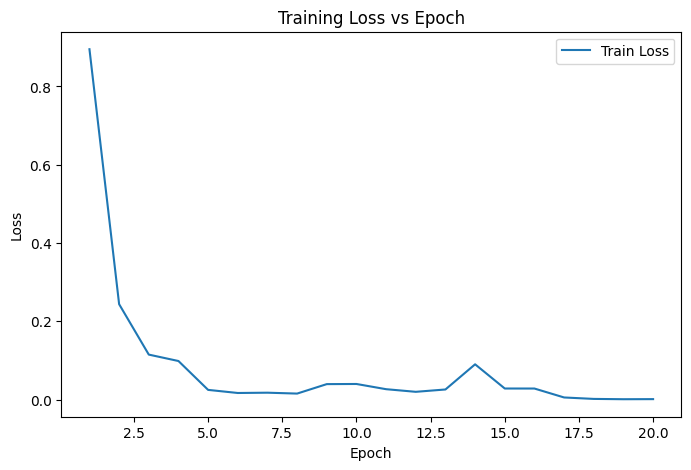

In [ ]:
import matplotlib.pyplot as plt
import os

full_train_loader = DataLoader(train_val_dataset, batch_size=32, shuffle=True, num_workers=64)

final_model = DenseNet121MLP(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss(weight= class_weights)
optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-4)

train_losses, val_losses, train_accs, val_accs = train_model_v2(
    model=final_model,
    train_loader=full_train_loader,
    val_loader=None,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20,
    final=True,
    save_dir='./Models'
)


os.makedirs('./Models', exist_ok=True)
torch.save(final_model.state_dict(), './Models/final_model_basic.pth')
print("Saved final model to ./Models/final_model.pth")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()


In [31]:
final_model.eval()
all_true = []
all_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_true.extend(labels.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())


Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file


Test Accuracy: 0.9615

Classification Report:
                    precision    recall  f1-score   support

     Purple_Blotch       0.82      0.91      0.86        69
            Thrips       1.00      1.00      1.00       103
              IYSV       1.00      1.00      1.00       140
           Healthy       0.99      1.00      0.99       221
          Bulb Rot       1.00      1.00      1.00       160
         Basal_Rot       0.88      0.83      0.85        35
       Stemphylium       0.91      0.90      0.90       125
Antracnose_Twister       0.96      0.92      0.94       213

          accuracy                           0.96      1066
         macro avg       0.94      0.95      0.94      1066
      weighted avg       0.96      0.96      0.96      1066



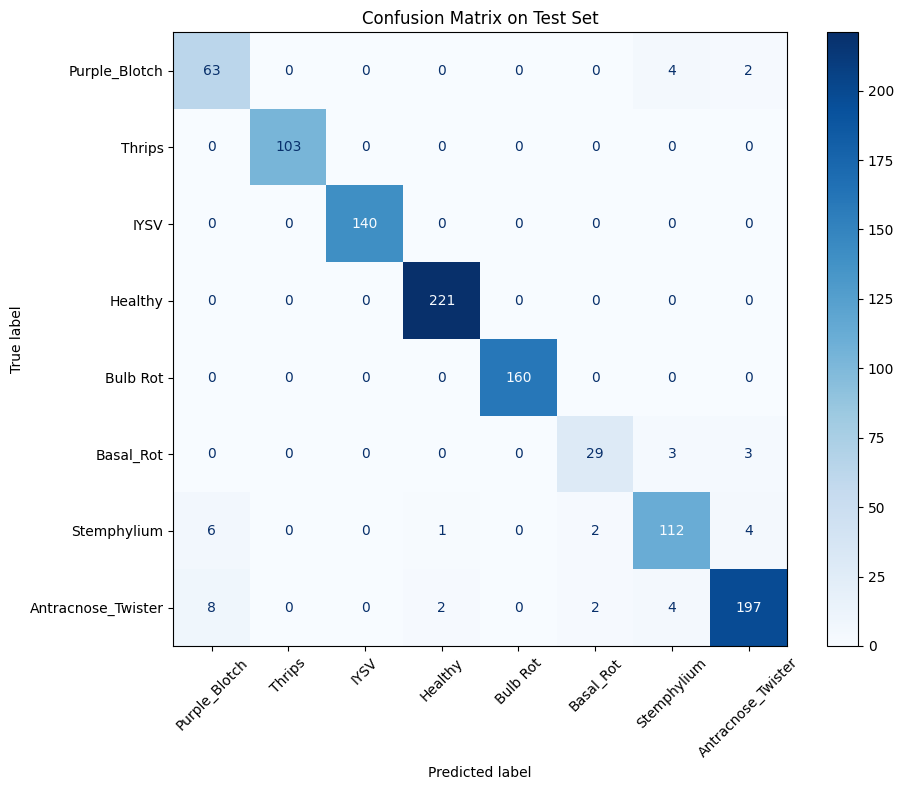

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

acc = accuracy_score(all_true, all_pred)
print(f"Test Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(all_true, all_pred, target_names=dataset.label_map.keys()))

cm = confusion_matrix(all_true, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(dataset.label_map.keys()))

fig, ax = plt.subplots(figsize=(10,8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import classification_report, accuracy_score

print("\n=== Cross Validation Metrics ===")
print(f"Overall CV Accuracy: {accuracy_score(all_true_labels_cv, all_pred_labels_cv):.4f}")
print(classification_report(all_true_labels_cv, all_pred_labels_cv, target_names=class_names))



=== Cross Validation Metrics ===
Overall CV Accuracy: 0.9374
                    precision    recall  f1-score   support

     Purple_Blotch       0.76      0.79      0.78       325
            Thrips       0.99      0.99      0.99       442
              IYSV       0.99      1.00      0.99       598
           Healthy       0.98      0.98      0.98       860
          Bulb Rot       1.00      0.99      1.00       548
         Basal_Rot       0.86      0.83      0.85       121
       Stemphylium       0.85      0.86      0.86       520
Antracnose_Twister       0.92      0.91      0.91       850

          accuracy                           0.94      4264
         macro avg       0.92      0.92      0.92      4264
      weighted avg       0.94      0.94      0.94      4264



In [ ]:
final_train_loader = DataLoader(train_val_dataset, batch_size=32, shuffle=True, num_workers=64)

final_model = models.densenet121(pretrained=True)
final_model.classifier = nn.Linear(final_model.classifier.in_features, num_classes)
final_model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(final_model.parameters(), lr=0.001)

num_epochs_final = 20

for epoch in range(num_epochs_final):
    final_model.train()
    running_loss = 0.0
    corrects = 0
    total = 0

    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        corrects += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(final_train_loader.dataset)
    epoch_acc = corrects / total
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")

torch.save(final_model.state_dict(), './Models/densenet121_final_model.pth')


/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid/ee-mariyam/maryam/miniconda3/envs/abhijeet/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
Epoch 1: Loss = 0.7803, Accuracy = 0.7270
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
Error load

Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7113.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file

=== Test Set Evaluation ===
Test Accuracy: 0.9428
                    precision    recall  f1-score   support

     Purple_Blotch       0.82      0.83      0.82        81
            Thrips       0.99      0.96      0.98       104
              IYSV       0.99      0.99      0.99       156
           Healthy       0.97      0.99      0.98       212
          Bulb R

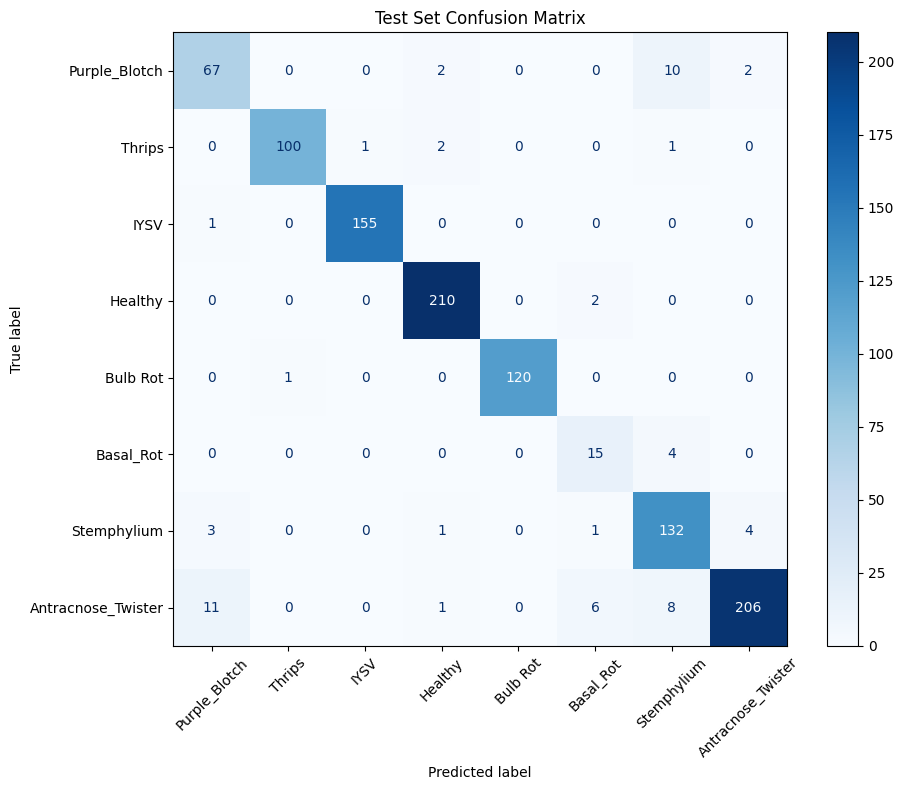

In [23]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

final_model.eval()
all_true_labels_test = []
all_pred_labels_test = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_true_labels_test.extend(labels.cpu().numpy())
        all_pred_labels_test.extend(predicted.cpu().numpy())

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

print("\n=== Test Set Evaluation ===")
print(f"Test Accuracy: {accuracy_score(all_true_labels_test, all_pred_labels_test):.4f}")
print(classification_report(all_true_labels_test, all_pred_labels_test, target_names=class_names))

cm = confusion_matrix(all_true_labels_test, all_pred_labels_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10,8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Test Set Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(all_true_labels_test, all_pred_labels_test, average='macro')
macro_recall = recall_score(all_true_labels_test, all_pred_labels_test, average='macro')
macro_f1 = f1_score(all_true_labels_test, all_pred_labels_test, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}")


In [ ]:
import numpy as np

all_true = np.array(all_true_labels_test)
all_pred = np.array(all_pred_labels_test)

class_wise_acc = {}

for i, class_name in enumerate(class_names):
    idxs = np.where(all_true == i)[0]
    correct = np.sum(all_pred[idxs] == all_true[idxs])
    acc = correct / len(idxs) if len(idxs) > 0 else 0
    class_wise_acc[class_name] = acc

print("\nClass-wise Accuracy:")
for class_name, acc in class_wise_acc.items():
    print(f"{class_name}: {acc:.4f}")



Class-wise Accuracy:
Purple_Blotch: 0.8272
Thrips: 0.9615
IYSV: 0.9936
Healthy: 0.9906
Bulb Rot: 0.9917
Basal_Rot: 0.7895
Stemphylium: 0.9362
Antracnose_Twister: 0.8879


In [ ]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects / total

        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_corrects += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects / val_total

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs} '
              f'Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_acc:.4f} '
              f'Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'denset121_twister_anthracnose_combined.pth')
            print(f'Saved best model with accuracy: {best_acc:.4f}')

    print('Training complete.')
    print(f'Best Validation Accuracy: {best_acc:.4f}')
    return train_losses, val_losses, train_accuracies, val_accuracies


train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)



Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7578.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7118.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7116.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7698.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7557.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_21_11_2023_DSC_7631.JPG: broken data stream when reading image file
Error loading image /raid/ee-mariyam/maryam/abhijeet

In [ ]:
plot_losses_and_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)

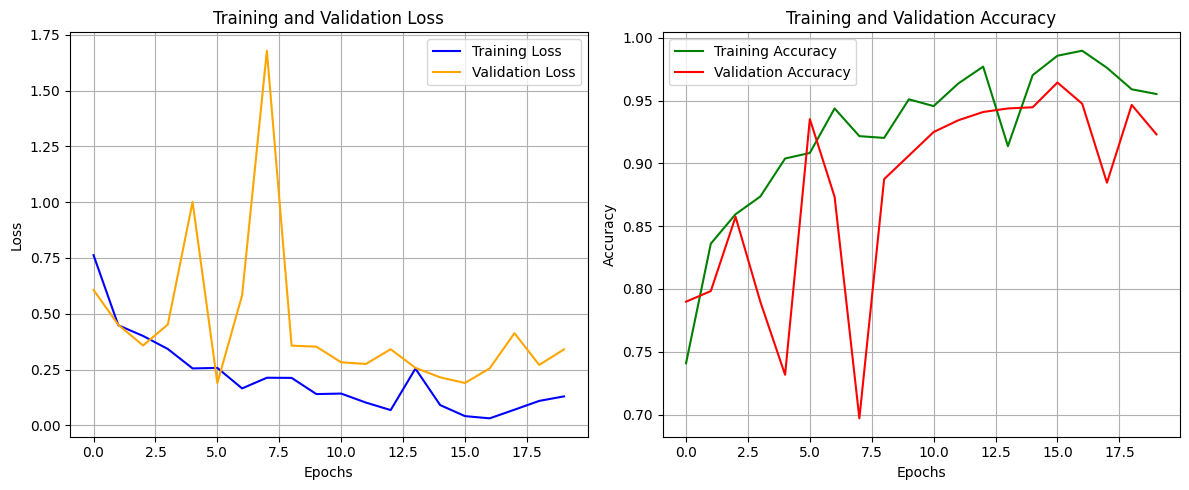

In [85]:
plot_losses_and_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)

In [86]:
model.load_state_dict(torch.load('denset121_twister_anthracnose_combined.pth'))
all_labels, all_preds = evaluate_model(model, val_loader)

Error loading image /raid/ee-mariyam/maryam/abhijeet/Combined_Files/Purple_Blotch/PB_D_E6_18_11_2023_DSC_7182.JPG: broken data stream when reading image file


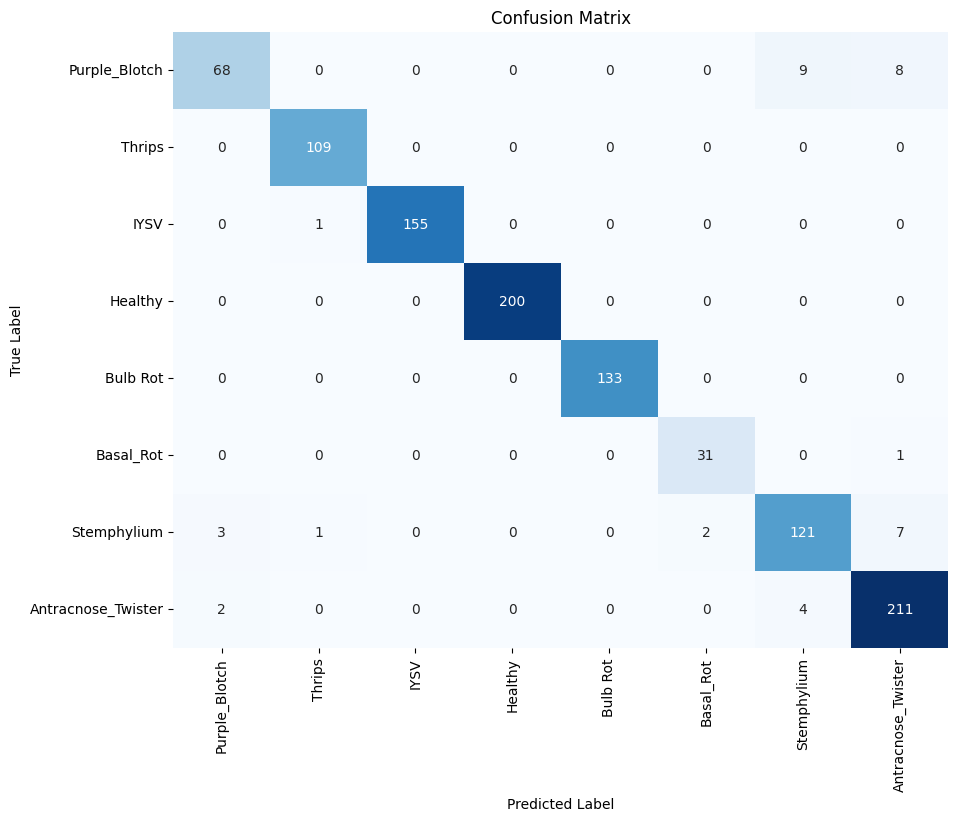

In [89]:
cm = confusion_matrix(all_labels, all_preds)
class_names = jpg_paths_comb_dict.keys()
num_classes=len(jpg_paths_comb_dict)
plot_confusion_matrix(cm, num_classes , class_names )

Total Accuracy: 96.44%
Class 'Purple_Blotch' Accuracy: 80.00%
Class 'Thrips' Accuracy: 100.00%
Class 'IYSV' Accuracy: 99.36%
Class 'Healthy' Accuracy: 100.00%
Class 'Bulb Rot' Accuracy: 100.00%
Class 'Basal_Rot' Accuracy: 96.88%
Class 'Stemphylium' Accuracy: 90.30%
Class 'Antracnose_Twister' Accuracy: 97.24%


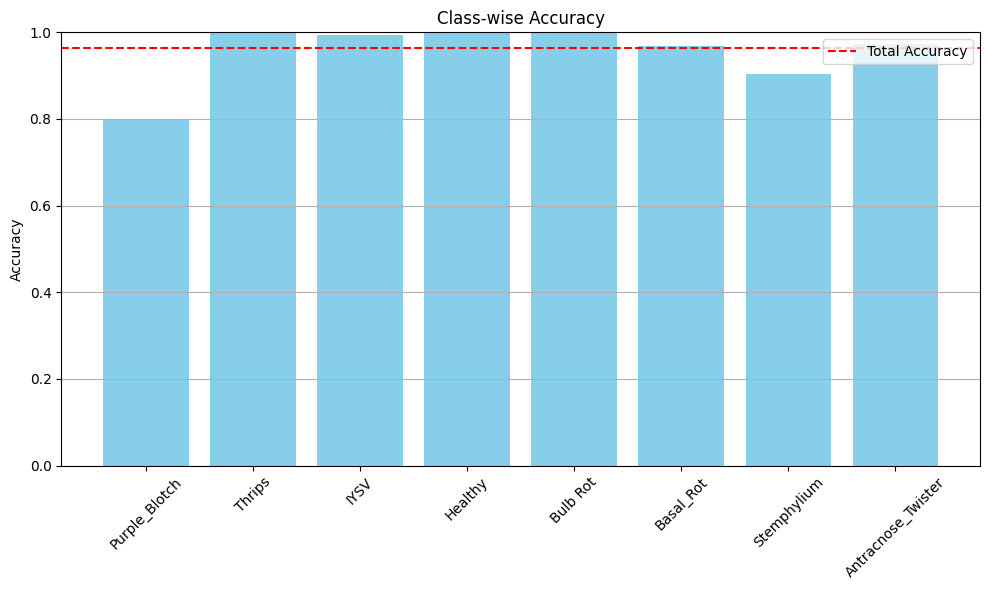

In [90]:
plot_classwise_accuracy(cm, jpg_paths_comb_dict)